#### **Library**

In [1]:
from google.colab import drive

# Mount Google-Drive Directory
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [22]:
!pip install -q contractions kagglehub

In [58]:
# general imports
import os
import re
import string
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import contractions
from PIL import Image
from collections import Counter
from matplotlib import pyplot as plt
from IPython.display import HTML, display
from sklearn.utils import shuffle
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings('ignore')


# spacy
import spacy

# Gensim
from gensim.models import Word2Vec, FastText, KeyedVectors
import gensim.parsing.preprocessing as gps
from gensim import utils


# NLTK
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from pathlib import Path
from google.colab import userdata
import kagglehub
from sklearn.utils import shuffle

In [24]:
FOLDER_PATH = Path(f"{userdata.get('FOLDER_PATH')}/SentXAI-Covid19")
%cd $FOLDER_PATH
# predictive-electric-vehicle

/content/gdrive/MyDrive/AI Models/SupervisedLearning/SentXAI-Covid19


#### **Dataset**

In [30]:
# Load data from kaggle
def pandas_df(path: str, file_name: str) -> pd.DataFrame:

    path = os.path.join(path, f"{file_name}")

    return pd.read_csv(path, encoding="latin1")

In [82]:
# https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification/data
PATH = kagglehub.dataset_download("datatattle/covid-19-nlp-text-classification")
pd.set_option("display.max_colwidth", 200)

# Load datasets
train_df = pandas_df(PATH, "Corona_NLP_train.csv")
test_df = pandas_df(PATH, "Corona_NLP_test.csv")

df = (
    pd.concat([train_df, test_df], axis=0)
    .rename(columns=str.lower)
    [["originaltweet", "sentiment"]]
    .rename(columns={"originaltweet": "tweet"})
)
df = shuffle(df, random_state=43).reset_index(drop=True)
df.head()

tweet  \
0                                                                Coronavirus Latest:Drivers In #NJ, Around Country Still Seeing Gas Prices Drop Amid COVID- - Mar 21 @ 10:28 AM ET https://t.co/zxLZVHbyVW   
1  ItÂs a difficult time for everyone at the moment but PLEASE do not stockpile and panic buy.. If you just buy what you need as normal there will be plenty of food and essential supplies for everyo...   
2                    Or buy gift certificates for others who may be in self-quarantine. A little online shopping will pass the time and keep local businesses alive. Plus, more books! #coronavirus #books   
3                                                                    "LA rental prices fall for the first time in a decade."\r\r\n#coronavirus #realestate #Investment \r\r\n\r\r\nhttps://t.co/1HniyhooOA   
4                                                                                                Covid-19 coronavirus: Rotorua shoppers wear beekeeping suits to supermarket ????? https://t.co/QfPj5KzN1p   

            sentiment  
0            Negative  
1  Extremely Positive  
2  Extremely Positive  
3             Neutral  
4             Neutral

In [89]:
dataframe = df.copy()

# Assign Labels
sentiment_labels = ['neg(-)', 'ext-pos(+)', 'neu(0)', 'ext-neg(-)', 'pos(+)']
map_labels = {k: c for c, k in zip(sentiment_labels, df["sentiment"].unique())}
dataframe["sentiment"] = df["sentiment"].map(map_labels)

#### **Data Overview**

In [90]:
# Data dimension
print("Dimension: ", dataframe.shape)

Dimension:  (44955, 2)


In [91]:
# Data Information
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      44955 non-null  object
 1   sentiment  44955 non-null  object
dtypes: object(2)
memory usage: 702.5+ KB


In [92]:
# Missing and Duplicates
print("\nNumber of missing values")
print("-" * 30)
print(dataframe.isna().sum())

print("\nNumber of duplicated values")
print("-" * 30)
print(dataframe.duplicated().sum())


Number of missing values
------------------------------
tweet        0
sentiment    0
dtype: int64

Number of duplicated values
------------------------------
0


In [106]:
sentiment_df = dataframe["sentiment"].value_counts().reset_index(name="size")

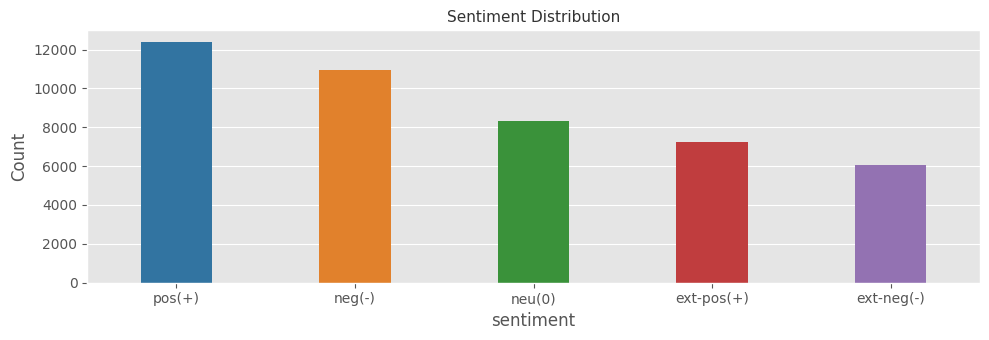

In [120]:
# Sentiment Plot Distribution
_, ax = plt.subplots(1, 1, figsize=(10, 3.5))
plt.style.use("ggplot")

sns.barplot(sentiment_df, x="sentiment", y="size", hue="sentiment", palette="tab10", gap=0.5, ax=ax)
ax.set_title("Sentiment Distribution", fontsize=11, alpha=0.8)
ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

#### **Data Processing & Cleaning**

In [ ]:
import nltk
from sklearn.feature_extraction import text

nltk.download("popular")
nltk.download('punkt_tab')

In [141]:
# Define Stopwords
words = np.unique(text.ENGLISH_STOP_WORDS.union(stopwords.words('english')))
stopword_list = [c for c in words]

# Define spacy lemmatization
spacy_lemma = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

In [142]:
# text preprocessing method
def text_processor(text):
    # case-fold each character
    text = text.strip().lower()

    # remove links & mentions
    text = re.sub(r'https:\W.+','', text)
    text = re.sub(r'@\w+|&\w+', '', text)

    # remove punctuations & emojis
    text = re.sub(r'[%s]'%re.escape(string.punctuation), ' ', text)

    # remove non-alphanumeric characters
    text = re.sub(r'\W+', ' ', text)

    # remove digits
    text = re.sub(r'\d+', ' ', text)
    # remove all stopwords
    text = ' '.join([word for word in word_tokenize(text) if word not in stopword_list])

    # lemmatize words into root-form & discard words with two characters
    text  = ' '.join([word.lemma_ for word in spacy_lemma(text) if len(word)>=2])

    return text


In [143]:
# Data Type Correction
dataframe = dataframe.astype(str)

# apply text preprocessing method
dataframe['text'] = dataframe.tweet.map(text_processor)

# calculate text length
dataframe['length'] = dataframe.text.map(len)

# consider dataframe points with length above
dataframe = dataframe[dataframe.length >= 5].drop(columns=['length'])

# remove both N/A and duplicated dataframe points
sort_columns = ["tweet", "text", "sentiment"]

dataframe = (
    dataframe[sort_columns]
    .dropna().drop_duplicates()
)

dataframe.head()

tweet  \
0                                                                Coronavirus Latest:Drivers In #NJ, Around Country Still Seeing Gas Prices Drop Amid COVID- - Mar 21 @ 10:28 AM ET https://t.co/zxLZVHbyVW   
1  ItÂs a difficult time for everyone at the moment but PLEASE do not stockpile and panic buy.. If you just buy what you need as normal there will be plenty of food and essential supplies for everyo...   
2                    Or buy gift certificates for others who may be in self-quarantine. A little online shopping will pass the time and keep local businesses alive. Plus, more books! #coronavirus #books   
3                                                                    "LA rental prices fall for the first time in a decade."\r\r\n#coronavirus #realestate #Investment \r\r\n\r\r\nhttps://t.co/1HniyhooOA   
4                                                                                                Covid-19 coronavirus: Rotorua shoppers wear beekeeping suits to supermarket ????? https://t.co/QfPj5KzN1p   

                                                                                                                                                                                                      text  \
0                                                                                                               coronavirus late driver in nj around country still see gas price drop amid covid mar be et   
1  itâ difficult time for everyone at the moment but please do not stockpile and panic buy if you just buy what you need as normal there will be plenty of food and essential supply for everyone think...   
2                                  or buy gift certificate for other who may be in self quarantine little online shopping will pass the time and keep local business alive plus more book coronavirus book   
3                                                                                                                      la rental price fall for the first time in decade coronavirus realestate investment   
4                                                                                                                                      covid coronavirus rotorua shopper wear beekeepe suit to supermarket   

    sentiment  
0      neg(-)  
1  ext-pos(+)  
2  ext-pos(+)  
3      neu(0)  
4      neu(0)

#### **Save Processed Data**

In [144]:
%%bash
# Create processed folder only if it does not exist in the folder tree.
FILE_DIR="processed"

if [[ ! -d "$FILE_DIR" ]]; then
    echo "Create '$FILE_DIR' folder ..."
    mkdir -p processed
else
    echo "Folder '$FILE_DIR' already exists."
fi

Create 'processed' folder ...


In [145]:
# Naming file output
FILE_NAME = "corona_tweets_covid19.csv"
FILE_OUTPUT = os.path.join("processed", FILE_NAME)

# Log existing files into file_log.txt
!find . -maxdepth 2 -type f > file_log.txt

# Load existing files into a pyton list
with open("file_log.txt", "r") as f:
    list_files = [file.split("/")[-1].rstrip() for file in f.readlines()]
    print(list_files)

['notebook_cleaning.ipynb', 'description', 'packed-refs', 'HEAD', 'config', 'index', '.gitignore', 'README.md', 'file_log.txt']


In [146]:
if FILE_NAME not in list_files:
    print("Saving processed dataset ...")
    dataframe.to_csv(FILE_OUTPUT, index=False)
else:
    print(f"File '{FILE_OUTPUT}' already created.")

Saving processed dataset ...


#### **Exploratory Data Analysis**

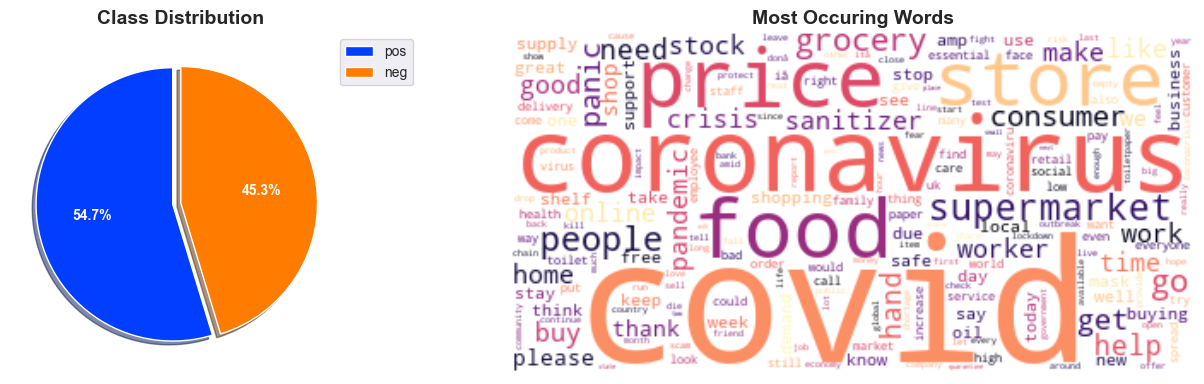

In [ ]:
# Pie-Chart plot for label distribution
label_counts = data.label.value_counts(normalize=True).to_dict()
y_label = list(label_counts.keys())
values = list(label_counts.values())

max_index = values.index(max(values))
explode = [0.06 if index==max_index else 0 for index in range(len(values))]

def class_distribution_plot(ax):
    ax.pie(
        x=values,
        explode=explode,
        colors=sns.color_palette('bright'),
        autopct='%1.1f%%',
        shadow=True,
        textprops=dict(color='w', size=10, weight='bold'),
        startangle=90,
    )

    ax.legend(labels=y_label, loc='upper right', fontsize='10', bbox_to_anchor=(1.2,1.))


# Word-Cloud for most existing words in the documents
word_tokens = Counter([w for tokens in data['clean_text'] for w in tokens.split()])
def cloud_plot(ax):
    text_cloud = WordCloud(
        stopwords=stop_words,
        max_words=200,max_font_size=100,
        background_color='white', colormap='magma',
        random_state=43)

    text_cloud.generate_from_frequencies(word_tokens,max_font_size=100)
    ax.imshow(text_cloud, interpolation='bilinear')
    ax.axis(False)


# combine plots
nrow=1
ncol=2
plt.figure(figsize=(14,4))
sns.set_theme(font_scale=1)

ax = plt.subplot2grid((nrow, ncol),(0,0))
class_distribution_plot(ax)
plt.title('Class Distribution', fontdict=dict(size=14, weight='bold'))

ax = plt.subplot2grid((nrow, ncol),(0,1))
cloud_plot(ax)
plt.title('Most Occuring Words', fontdict=dict(size=14, weight='bold'))
plt.tight_layout()
plt.show()


* Positive and negative sentiments are almost evenly distributed.
* The tweets primarily discuss topics related to the coronavirus, food, prices, stores, etc.
* The most frequently occurring words pertain to activities commonly discussed during the COVID-19 pandemic.

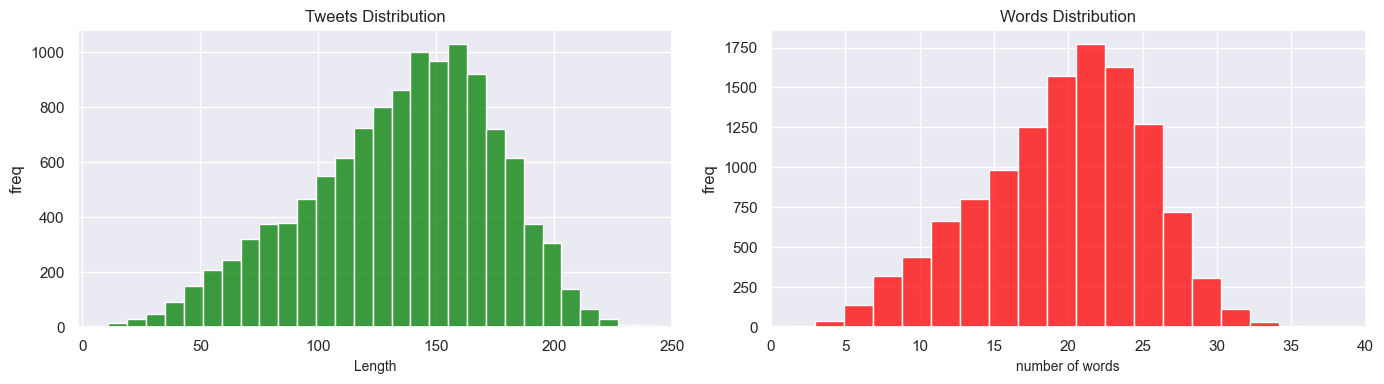

In [ ]:
# Document length distribution (character & word level)
doc_df = pd.DataFrame([(row['label'], len(row['clean_text']), len(row['clean_text'].split()))
                                 for _, row in data.iterrows()], columns=['label', 'fact_length', 'number_words'])

def char_distribution_plot(ax):

    sns.histplot(doc_df,binwidth=8, x='fact_length',ax=ax, color='green')

    ax.set_xlim((-2, 250))
    ax.set_ylabel('freq')
    ax.set_title('Tweets Distribution')
    ax.set_xlabel('Length', fontdict=dict(size=10, weight='normal'))

def words_distribution_plot(ax):

    sns.histplot(data=doc_df, x='number_words', ax=ax,binwidth=2,color='red')
    ax.set_xlim((0, 40))
    ax.set_ylabel('freq')
    ax.set_title('Words Distribution')
    ax.set_xlabel('number of words', fontdict=dict(size=10, weight='normal'))

# plot distributions
plt.figure(figsize=(14,4))
sns.set_theme(font_scale=1)
nrow=1
ncol=2

ax = plt.subplot2grid((nrow, ncol),(0,0))
char_distribution_plot(ax)

ax = plt.subplot2grid((nrow, ncol),(0,1))
words_distribution_plot(ax)

plt.tight_layout()
plt.show()

* The majority of tweets are around 150 characters in length.
* Most tweets consist of approximately 22 words.

#### **Train & Test Split**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix

In [ ]:
modelpoint = data.reset_index(drop=True) # reset indices to orderly flow
modelpoint['label'] = modelpoint['label'].map(label_to_index) # encode labels data

X, y = modelpoint.text.values, modelpoint.label.values

# train-test split
def training_testing_set() -> tuple:
    X_train, X_test, y_train, y_test = train_test_split(X.flatten(), y, test_size=0.2,random_state=43, stratify=y)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,random_state=43)

    return (X_train, y_train.reshape(-1,1)), (X_val, y_val.reshape(-1, 1)), (X_test, y_test)


# Train, Val and Test Sets
train, val, test = training_testing_set()

x_train, y_train = train
x_val, y_val = val
x_test, y_test = test

#### **Text Transformer (Preprocessing)**

In [ ]:
# Text preprocesing class
class TextTransformer(BaseEstimator, TransformerMixin):
    '''
        * Custom text-transformer will be used as part of the model pipeline
    '''
    # text preprocessing method
    def __text_processor(self, text):
        # case-fold each character
        text = text.strip().lower()

        # remove links & mentions
        text = re.sub(r'https:\W.+','', text)
        text = re.sub(r'@\w+|&\w+', '', text)

        # remove punctuations & emojis
        text = re.sub(r'[%s]'%re.escape(string.punctuation), ' ', text)

        # remove non-alphanumeric characters
        text = re.sub(r'\W+', ' ', text)

        # remove digits
        text = re.sub(r'\d+', ' ', text)
        # remove all stopwords
        text = ' '.join([word for word in word_tokenize(text) if word not in stop_words])

        # lemmatize words into root-form & discard words with less than two characters
        text  = ' '.join([word.lemma_ for word in spacy_lemma(text) if len(word)>=2])

        return text

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        text = [self.__text_processor(s) for s in X]
        return [word_tokenize(s) for s in text]

#### **Feature Engineering**

> #### Word2Vec Embedding

In [ ]:
#Build Embedding Model
def w2v_embedding(x_input, skip_gram=0):
    x_input = [list(w) for w in x_input]
    model = Word2Vec(
        sg=skip_gram,
        vector_size=300,
        min_count=5,
        window=5,
        seed=43,
    )

    model.build_vocab(x_input)
    model.train(x_input, total_examples=model.corpus_count, epochs=200)

    return model


In [ ]:
# words corpus
corpus_data = [sentence.split() for sentence in data.clean_text.to_numpy()]

In [ ]:
%%time
# Word2Vec-CBOW
w2v_model_cbow = w2v_embedding(corpus_data, skip_gram=0)

CPU times: total: 1min 37s
Wall time: 1min 8s


In [ ]:
%%time
# Word2Vec-Skip-Gram
w2v_model_skip = w2v_embedding(corpus_data, skip_gram=1)

CPU times: total: 5min 7s
Wall time: 2min 51s


In [ ]:
%%time
# change working directory
file_path = os.path.join(working_dir, r'keyed-vectors')

try:
    os.makedirs(file_path,)
except FileExistsError:
    print('File already exists!')

os.chdir(file_path)
# save keyedvectors
w2v_model_cbow.wv.save('cbow.wordvectors')
w2v_model_skip.wv.save('skgram.wordvectors')

# change back to main working directory
os.chdir(working_dir)

File already exists!
CPU times: total: 15.6 ms
Wall time: 72.7 ms


In [ ]:
# Embedding-Transformer
class Word2VecTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, embedding_vector):
        self.embedding_vector = embedding_vector

    def __word_embedding_vector(self, sentence):
        average = []
        for word in sentence:
            if word in  self.embedding_vector.index_to_key:
                average.append(self.embedding_vector[word])

        if not average:
            return np.zeros(self.embedding_vector.vector_size)
        else:
            return np.array(average).mean(axis=0)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        xs = [self.__word_embedding_vector(sentence) for sentence in X]
        return xs


In [ ]:
# Word2Vector Embedding Pipeline
class W2VModel:

    def __init__(self, model, x_train, y_train):
        self.model = model
        self.x_train = x_train
        self.y_train = y_train

    def train_model(self, title, embedding_vector):
        pipeline = Pipeline([
            ('preprocessor', TextTransformer()),
            (f'{title}-embedding', Word2VecTransformer(embedding_vector)),
            ('model', self.model)
        ])

        pipeline = pipeline.fit(self.x_train, self.y_train)
        return pipeline

>#### TF-IDF Approach

In [ ]:
class TFIDFCustomTransformer(BaseEstimator, TransformerMixin):

     def __dummy(self, doc):
          return doc

     def fit(self, X, y=None):
          return self

     def transform(self, X):
          vectorizer = TfidfVectorizer(
                analyzer='word',
                tokenizer=self.__dummy,
                preprocessor=self.__dummy,
                ngram_range=(1,3))
          return vectorizer.fit_transform(X)

In [ ]:
# TFIDF Model Pipeline
class TFModel:

    def __init__(self, model, x_train, y_train):
        # Initialize attributes
        self.model = model
        self.x_train = x_train
        self.y_train = y_train

    def dummy(self, doc):
        return doc

    def train_model(self):

        pipeline = Pipeline([
            ('preprocessor', TextTransformer()),
            (f'tf-idf',TfidfVectorizer(
                analyzer='word',
                tokenizer=self.dummy,
                preprocessor=self.dummy,
                ngram_range=(1,3))),
            ('model', self.model)
        ])

        pipeline = pipeline.fit(self.x_train, self.y_train)
        return pipeline

#### **Build Models**

In [ ]:
import copy
import joblib
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

> #### Evaluation

In [ ]:
class ModelEval:
    '''
        * The class takes in a sklearn-pipeline, x and y-validations as inputs
        *
    '''
    def __init__(self, pipeline,x_val, y_val):

        # input attributes
        self.x_val = x_val
        self.y_val = y_val
        self.pipeline =  pipeline

        # perfoms predictions
        self.predicted =  self.pipeline.predict_proba(self.x_val)

        # round floating points into 3 decimals
        self.format_matric = lambda x: float('{:,.3f}'.format(x))

    # return predicted values
    def get_predictions(self):
        return self.predicted

    # return metrics
    def get_metrics(self):

        # accuracy score
        acc = accuracy_score(self.y_val , self.predicted.argmax(axis=-1))

        # f1-score
        f1 = f1_score(self.y_val , self.predicted.argmax(axis=-1), average='weighted')

        # log metrics
        metric_values = dict(accuracy= self.format_matric(acc), f1= self.format_matric(f1))

        return metric_values

    # show indivial performance per class
    def show_classification_report(self):
        print(classification_report(self.y_val , self.predicted.argmax(axis=-1), target_names=label_to_index.keys()))

    # output confusion matrix
    def confusion_matrix_plot(self, cmap='inferno'):
        # finding confusion title
        pipeline_keys = list(self.pipeline.named_steps.keys())
        model_name = self.pipeline.named_steps['model'].__class__.__name__.lower()
        model_alias = pipeline_keys[1] + "-" + model_name
        # # #


        fig, ax = plt.subplots(1,1, figsize=(10,6))
        labels = list(label_to_index.keys())
        ticks =list(label_to_index.values())

        confusion_mat = confusion_matrix(y_val, self.predicted.argmax(axis=-1))
        sns.heatmap(confusion_mat, annot=True, fmt='.1f', cmap=cmap,cbar=False, ax=ax)

        ax.set_xticklabels(labels)
        ax.set_xlabel('True Labels',  fontsize='11', fontweight='bold')
        ax.set_yticks(ticks, labels, rotation=0)
        ax.set_yticklabels(list(label_to_index.keys()))
        ax.set_title(f'Confusion matrix for {model_alias}', fontsize='12')
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels', fontsize='11', fontweight='bold')

        plt.tight_layout()
        plt.show()

>#### Serializer &  Deserializer

In [ ]:
class ModelBinarizer:
    def __init__(self, path):
        self.path = path

    # serialize
    def save_model(self, model, file_name):
        with open(os.path.join(self.path, file_name), 'wb') as file:
            try:
                joblib.dump(model, file)
                print(f'Pipeline has been saved successful as {file_name}')
            except Exception as exp:
                print(f'Saving pipeline failed with the following error: {exp}')
            finally:
                print('Process completed!!')

    # deserialize
    def load_model(self, file_name):
        with open(os.path.join(self.path, file_name), 'rb') as file:
            try:
                return joblib.load(file)
            except Exception as exp:
                print(f'File loading failed with the follwoing exception: {exp}')
            finally:
                print('Process completed!!')

> #### Additional information

In [ ]:
%%time
# change working directory
os.chdir(file_path)

# Load keyed-vectors
cbow_keyedvectors = KeyedVectors.load('cbow.wordvectors')
sg_keyedvectors  = KeyedVectors.load('skgram.wordvectors')

# change back to main working directory
os.chdir(working_dir)

CPU times: total: 0 ns
Wall time: 1.02 s


In [ ]:
# initialize serialization and deserialization
model_path = os.path.join(working_dir, r'trained-models')

try:
    os.makedirs(model_path)
except FileExistsError:
    print('File already exists!')

save_load_model = ModelBinarizer(model_path)

>##### Logistic Model

In [ ]:
# initialize model
lr_params = dict(
    penalty='l2', C=5,
    max_iter=500,multi_class='multinomial',
    solver='lbfgs', random_state=43
)

lr = LogisticRegression(**lr_params)

In [ ]:
%%time
# lr-skip-gram
w2v_model = W2VModel(lr, x_train=x_train, y_train=y_train) # initial embedding model
trained_model = w2v_model.train_model('skip', sg_keyedvectors) # train model
pipeline = copy.deepcopy(trained_model) # deep copy pipeline to prevent a model from being overridden
save_load_model.save_model(pipeline, r'lr_sg_pipe.joblib') # save model to local directory

# release memory
del w2v_model
del pipeline
del trained_model

Pipeline has been saved successful as lr_sg_pipe.joblib
Process completed!!
CPU times: total: 16.3 s
Wall time: 46.3 s


Process completed!!
{'accuracy': 0.897, 'f1': 0.897}
              precision    recall  f1-score   support

         neg       0.88      0.89      0.89       872
         pos       0.91      0.90      0.91      1061

    accuracy                           0.90      1933
   macro avg       0.90      0.90      0.90      1933
weighted avg       0.90      0.90      0.90      1933



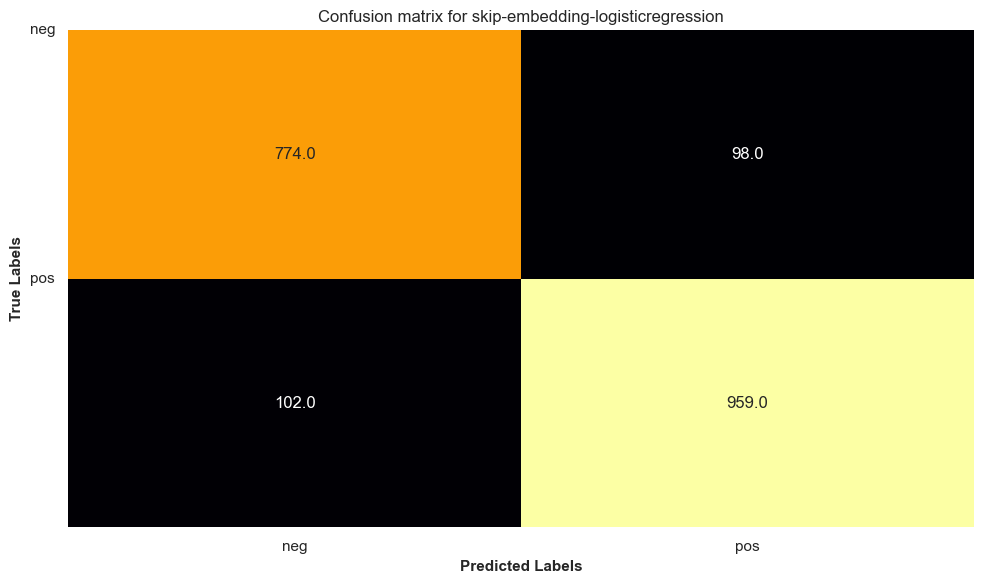

CPU times: total: 4.06 s
Wall time: 56.2 s


In [ ]:
%%time
## evaluation
lr_sg = save_load_model.load_model('lr_sg_pipe.joblib') # load model pipeline

lr_sg_eval = ModelEval(lr_sg, x_val, y_val) # load evaluation pipeline
lr_sg_metrics = lr_sg_eval.get_metrics() # retrieve model overall metrics

print(lr_sg_metrics)

# classification report
lr_sg_eval.show_classification_report()

# confusion metrix
lr_sg_eval.confusion_matrix_plot()


In [ ]:
%%time
# lr-cbow-gram
w2v_model = W2VModel(lr, x_train=x_train, y_train=y_train)
trained_model = w2v_model.train_model('cbow', cbow_keyedvectors)
pipeline = copy.deepcopy(trained_model)
save_load_model.save_model(pipeline, r'lr_cb_pipe.joblib')
del w2v_model
del pipeline
del trained_model

Pipeline has been saved successful as lr_cb_pipe.joblib
Process completed!!
CPU times: total: 18.2 s
Wall time: 35.8 s


Process completed!!
{'accuracy': 0.91, 'f1': 0.91}
              precision    recall  f1-score   support

         neg       0.90      0.90      0.90       872
         pos       0.92      0.92      0.92      1061

    accuracy                           0.91      1933
   macro avg       0.91      0.91      0.91      1933
weighted avg       0.91      0.91      0.91      1933



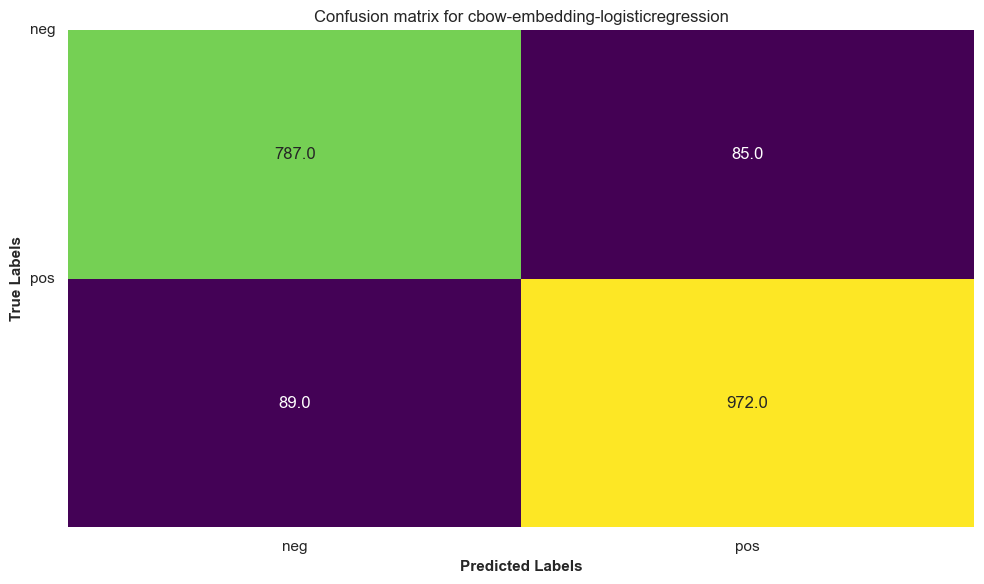

CPU times: total: 4.28 s
Wall time: 10.9 s


In [ ]:
%%time
## evaluation
lr_cb = save_load_model.load_model('lr_cb_pipe.joblib')

lr_cb_eval = ModelEval(lr_cb, x_val, y_val)
lr_cb_metrics = lr_cb_eval.get_metrics()


print(lr_cb_metrics)

# classification report
lr_cb_eval.show_classification_report()

# confusion metrix
lr_cb_eval.confusion_matrix_plot(cmap='viridis')

In [ ]:
%%time
# lr-tf-idf
tfidf_model = TFModel(lr, x_train=x_train, y_train=y_train)
trained_model = tfidf_model.train_model()
pipeline = copy.deepcopy(trained_model)
save_load_model.save_model(pipeline, r'lr_tf_pipe.joblib')

del trained_model
del tfidf_model
del pipeline

Pipeline has been saved successful as lr_tf_pipe.joblib
Process completed!!
CPU times: total: 20.9 s
Wall time: 1min 39s


Process completed!!
{'accuracy': 0.935, 'f1': 0.935}
              precision    recall  f1-score   support

         neg       0.94      0.92      0.93       872
         pos       0.93      0.95      0.94      1061

    accuracy                           0.93      1933
   macro avg       0.94      0.93      0.93      1933
weighted avg       0.93      0.93      0.93      1933



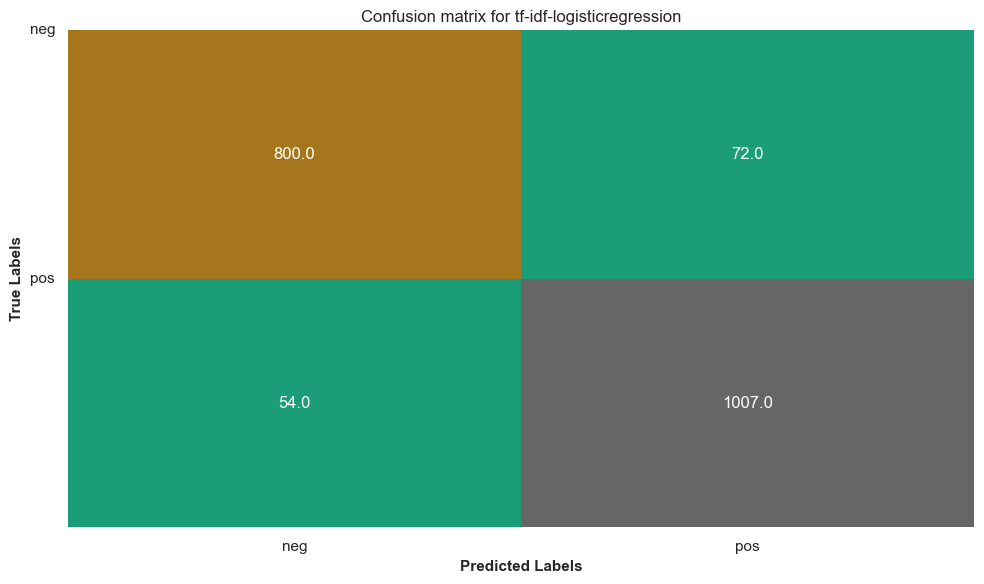

CPU times: total: 4.39 s
Wall time: 10.9 s


In [ ]:
%%time
## evaluation
lr_tf = save_load_model.load_model(r'lr_tf_pipe.joblib')

lr_tf_eval = ModelEval(lr_tf, x_val, y_val)
lr_tf_metrics = lr_tf_eval.get_metrics()

print(lr_tf_metrics)

# classification report
lr_tf_eval.show_classification_report()

# confusion metrix
lr_tf_eval.confusion_matrix_plot(cmap='Dark2')

>#### Support-Vector Model

In [ ]:
# define model
svm_params = dict(C=5, kernel='rbf', probability=True)
svm = SVC(**svm_params)

In [ ]:
%%time
# svm-skip-gram
w2v_model = W2VModel(svm, x_train=x_train, y_train=y_train)
trained_model = w2v_model.train_model('skip', sg_keyedvectors)
pipeline = copy.deepcopy(trained_model)
save_load_model.save_model(pipeline, r'svm_sg_pipe.joblib')
del w2v_model
del pipeline
del trained_model

Pipeline has been saved successful as svm_sg_pipe.joblib
Process completed!!
CPU times: total: 40.3 s
Wall time: 1min 29s


Process completed!!
{'accuracy': 0.915, 'f1': 0.915}
              precision    recall  f1-score   support

         neg       0.90      0.91      0.91       872
         pos       0.92      0.92      0.92      1061

    accuracy                           0.92      1933
   macro avg       0.91      0.91      0.91      1933
weighted avg       0.92      0.92      0.92      1933



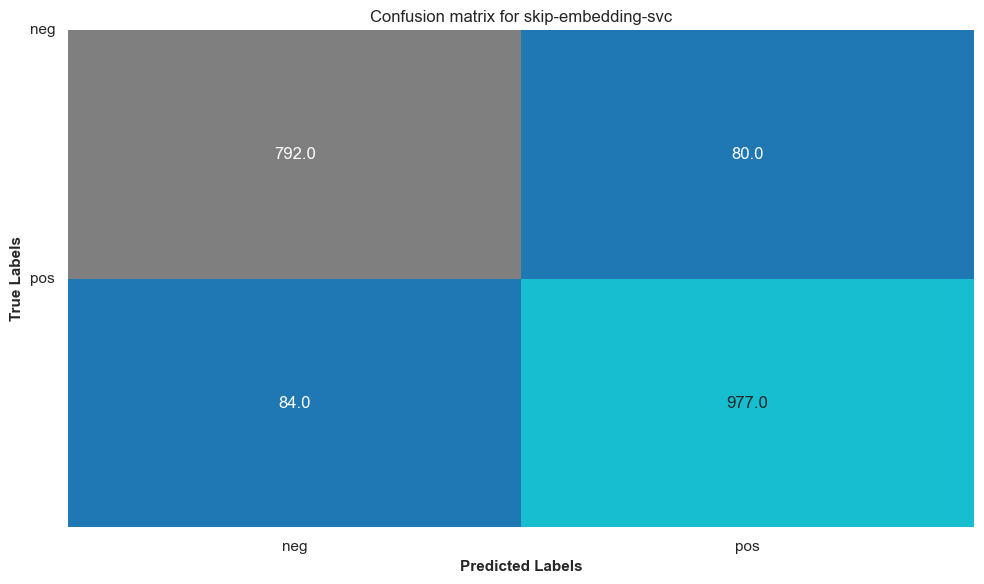

CPU times: total: 5.06 s
Wall time: 11.1 s


In [ ]:
%%time
## evaluation
svm_sg = save_load_model.load_model(r'svm_sg_pipe.joblib')

svm_sg_eval = ModelEval(svm_sg, x_val, y_val)
svm_sg_metrics = svm_sg_eval.get_metrics()

print(svm_sg_metrics)

# classification report
svm_sg_eval.show_classification_report()

# confusion metrix
svm_sg_eval.confusion_matrix_plot(cmap='tab10')

In [ ]:
%%time
# svm-cbow-gram
w2v_model = W2VModel(svm, x_train=x_train, y_train=y_train)
trained_model = w2v_model.train_model('cbow', cbow_keyedvectors)
pipeline = copy.deepcopy(trained_model)
save_load_model.save_model(pipeline, r'svm_cb_pipe.joblib')
del w2v_model
del pipeline
del trained_model

Pipeline has been saved successful as svm_cb_pipe.joblib
Process completed!!
CPU times: total: 35.6 s
Wall time: 1min 23s


Process completed!!
{'accuracy': 0.921, 'f1': 0.921}
              precision    recall  f1-score   support

         neg       0.91      0.91      0.91       872
         pos       0.93      0.93      0.93      1061

    accuracy                           0.92      1933
   macro avg       0.92      0.92      0.92      1933
weighted avg       0.92      0.92      0.92      1933



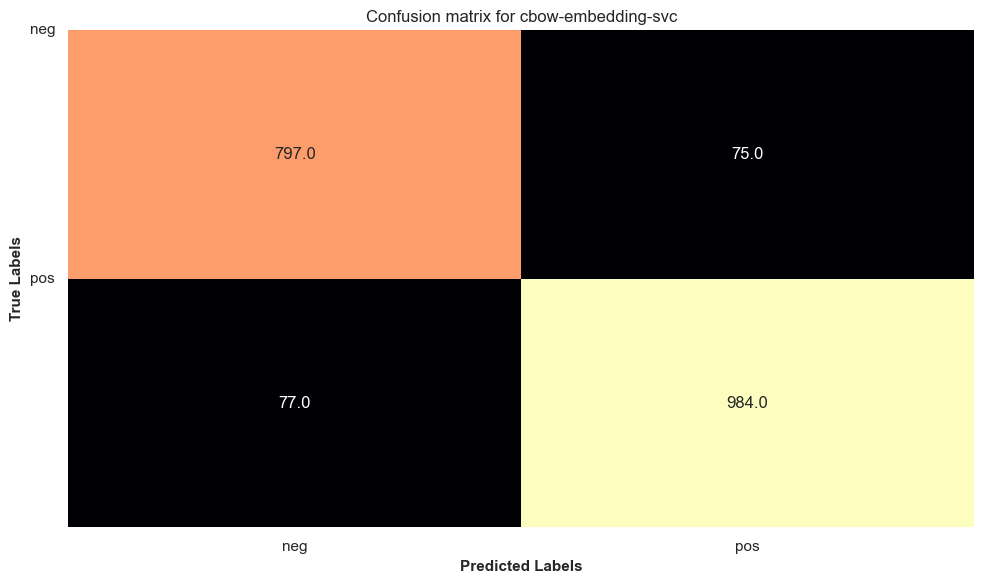

CPU times: total: 6 s
Wall time: 11.1 s


In [ ]:
%%time
## evaluation
svm_cb = save_load_model.load_model(r'svm_cb_pipe.joblib') # load pipeline from local directory

svm_cb_eval = ModelEval(svm_cb, x_val, y_val) # load model evaluation pipeline
svm_cb_metrics = svm_cb_eval.get_metrics() # retrive overall model metrics

print(svm_cb_metrics)

# classification report
svm_cb_eval.show_classification_report()

# confusion metrix
svm_cb_eval.confusion_matrix_plot(cmap='magma')

In [ ]:
%%time
# svm-tf-idf
tfidf_model = TFModel(svm, x_train=x_train, y_train=y_train) # load TF-IDF Pipeline
trained_model = tfidf_model.train_model() # train TF-IDF Pipeline
pipeline = copy.deepcopy(trained_model) # deepcopy trained model - prevent a model from overridden
save_load_model.save_model(pipeline, r'svm_tf_pipe.joblib') # save a model to local directory

del tfidf_model # realse memory
del pipeline
del trained_model

Pipeline has been saved successful as svm_tf_pipe.joblib
Process completed!!
CPU times: total: 1min 28s
Wall time: 2min 58s


Process completed!!
{'accuracy': 0.929, 'f1': 0.929}
              precision    recall  f1-score   support

         neg       0.92      0.92      0.92       872
         pos       0.94      0.93      0.94      1061

    accuracy                           0.93      1933
   macro avg       0.93      0.93      0.93      1933
weighted avg       0.93      0.93      0.93      1933



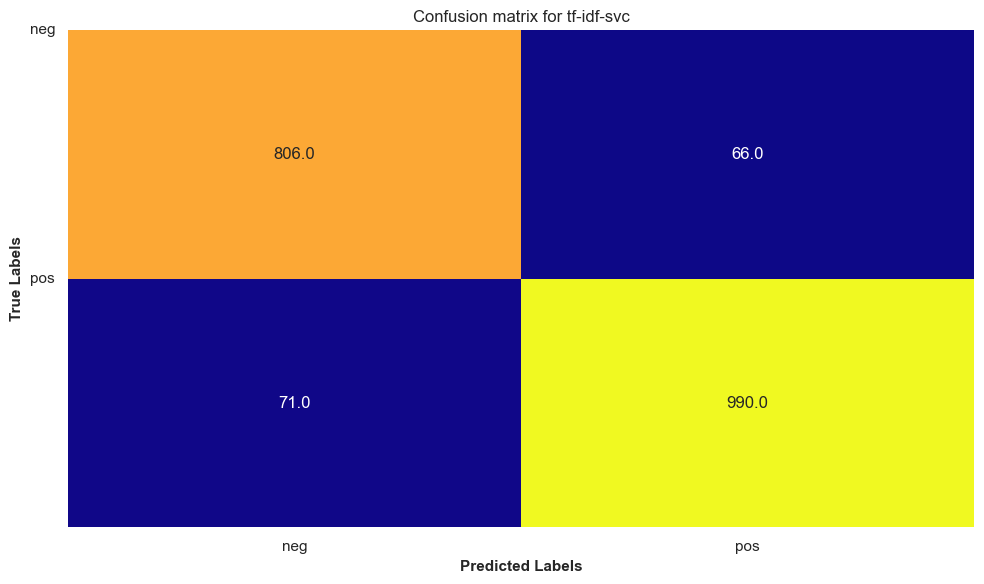

CPU times: total: 6.56 s
Wall time: 16.8 s


In [ ]:
%%time
## evaluation
svm_tf = save_load_model.load_model(r'svm_tf_pipe.joblib')

svm_tf_eval = ModelEval(svm_tf, x_val, y_val)
svm_tf_metrics = svm_tf_eval.get_metrics()

print(svm_tf_metrics)

# classification report
svm_tf_eval.show_classification_report()

# confusion metrix
svm_tf_eval.confusion_matrix_plot(cmap='plasma')

> ##### Compare Models

In [ ]:
score_df = pd.DataFrame(columns=['model', 'accuracy', 'f1-score'])

score_df.loc[len(score_df.index)] = ['lr-sgram', *list(lr_sg_metrics.values())]
score_df.loc[len(score_df.index)] = ['lr-cbow', *list(lr_cb_metrics.values())]
score_df.loc[len(score_df.index)] = ['lr-tfidf', *list(lr_tf_metrics.values())]
score_df.loc[len(score_df.index)] = ['svm-sgram' , *list(svm_sg_metrics.values())]
score_df.loc[len(score_df.index)] = ['svm-cbow', *list(svm_cb_metrics.values())]
score_df.loc[len(score_df.index)] = ['svm-tfidf', *list(svm_tf_metrics.values())]
score_df.sort_values(['accuracy', 'f1-score'], ascending=False, axis=0, inplace=True)
score_df.reset_index(drop=True, inplace=True)

In [ ]:
from IPython.display import HTML, display

display(score_df)

model  accuracy  f1-score
0   lr-tfidf     0.935     0.935
1  svm-tfidf     0.929     0.929
2   svm-cbow     0.921     0.921
3  svm-sgram     0.915     0.915
4    lr-cbow     0.910     0.910
5   lr-sgram     0.897     0.897

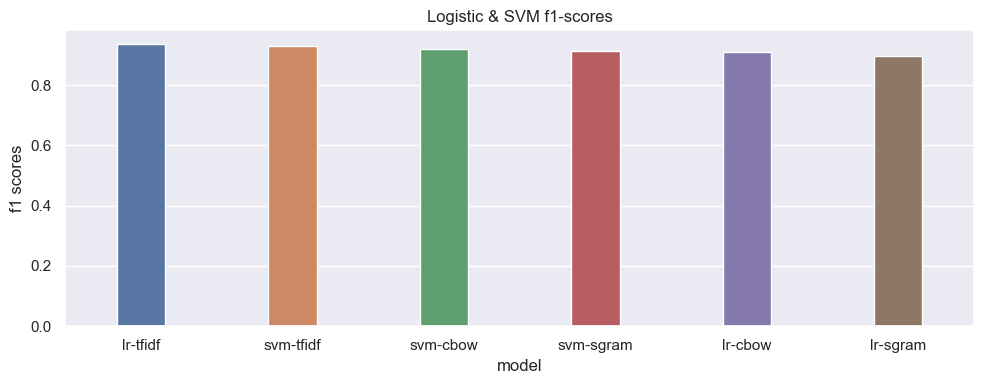

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
sns.set_theme(font_scale=1, context='notebook')

temp_df = score_df.sort_values(['f1-score'], ascending=False, axis=0)
sns.barplot(temp_df, x='model', y='f1-score', hue='model', gap=0.6, ax=ax)
# ax.set_xticks(labels=)
# ax.legend(title='accuracy-scores', loc=4)
ax.set_ylabel('f1 scores')
ax.set_xlabel('model')
ax.set_title('Logistic & SVM f1-scores')
plt.tight_layout()
plt.show()

del temp_df

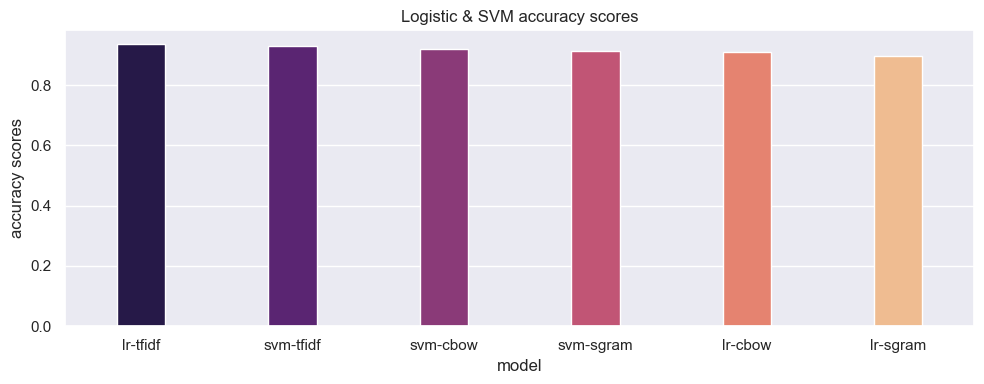

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
sns.set_theme(font_scale=1, context='notebook')
temp_df = score_df.sort_values(['accuracy'], ascending=False, axis=0)
sns.barplot(temp_df, x='model', y='accuracy', hue='model', palette='magma', gap=0.6, ax=ax)
# ax.set_xticks(labels=)
# ax.legend(title='accuracy-scores', loc=4)
ax.set_ylabel('accuracy scores')
ax.set_xlabel('model')
ax.set_title('Logistic & SVM accuracy scores')
plt.tight_layout()
plt.show()
del temp_df

##### Model Results
* All models demonstrated impressive accuracy and F1-scores.
* Logistic Regression with TF-IDF attained the highest overall scores.
* Selecting the best model solely based on traditional metrics may introduce bias.
* In the next step, we assess how well a model generalizes its predictions by examining feature importances.
* The optimal model is selected based on the clarity and interpretability of its predictions from a human perspective.

#### **LIME - Explainable AI (XAI)**

In [ ]:
from lime.lime_text import LimeTextExplainer
from sklearn.utils import shuffle


In [ ]:
# initialize model explainer
def show_explaination(pipeline, input_text: str):

    predict_val = pipeline.predict_proba([input_text])
    map_val = predict_val.argmax(axis=-1)[0]


    pipeline_keys = list(pipeline.named_steps.keys())
    model_name = pipeline.named_steps['model'].__class__.__name__.lower()
    model_alias = pipeline_keys[1] + "-" + model_name

    print(f'Model: {model_alias}')
    print('The predicted Output: ', index_to_label.get(map_val))

    explainer = LimeTextExplainer(class_names=['negative', 'positive'])
    exp = explainer.explain_instance(input_text, pipeline.predict_proba,num_features=6)
    exp.show_in_notebook(text=True)

In [ ]:
# Randomly select sample input from test data
rows = len(x_test)
# index = np.random.randint(0, rows)
index = 2369
x_input  = x_test[index]
true_label = y_test[index]

print(f'Input Data: {x_input}')
print(f'Actual Output:', index_to_label[true_label])

#  @HeriOnlineS is with you in the fight against COVID 19 infection,

# We believe in social distancing  to avoid contact.

# Heri ensures you don't have to worry about your shopping do it from your safest space and we shall deliver

# https://t.co/Dm

Input Data: @HeriOnlineS is with you in the fight against COVID 19 infection,

We believe in social distancing  to avoid contact.

Heri ensures you don't have to worry about your shopping do it from your safest space and we shall deliver 

https://t.co/Dm
Actual Output: neg


> ##### SVM Skip-Gram Model

In [ ]:
show_explaination(svm_sg, x_input)

Model: skip-embedding-svc
The predicted Output:  neg


**Support Vector Machine**
- skipgram word2vec: correcly predict tweet as negative, but attributed words such as Heri (name of a person) and https (web-link) towards negative sentiment which may be misleading
-


> ##### SVM (CBOW) Model

In [ ]:
show_explaination(svm_cb, x_input)

Model: cbow-embedding-svc
The predicted Output:  neg


> ##### SVM(TF-IDF) Model

In [ ]:
show_explaination(svm_tf, x_input)

Model: tf-idf-svc
The predicted Output:  neg


> ##### Logistic Skip-Gram Model

In [ ]:
show_explaination(lr_sg, x_input)

Model: skip-embedding-logisticregression
The predicted Output:  pos


> ##### Logistic (BOW) model

In [ ]:
show_explaination(lr_cb, x_input)

Model: cbow-embedding-logisticregression
The predicted Output:  neg


> ##### logistic tf-idf model

In [ ]:
show_explaination(lr_tf, x_input)

Model: tf-idf-logisticregression
The predicted Output:  neg


#### **Results & Discussion**

Support Vector Machine:
- *Skip-gram Word2Vec:* Correctly predicted the tweet as negative but incorrectly attributed neutral words like "Heri" (a name) and "https" (a web link) to negative sentiment.
- *CBOW Word2Vec:* Correctly predicted the tweet as negative but misattributed neutral words like "believe" and "social" to negative sentiments.
- *TF-IDF:* Correctly predicted the tweet as negative and correctly attributed the word "Heri" to negative sentiment.
- The misattribution of positive or neutral words to negative sentiments indicates potential issues with the model's accuracy.

Logistic Regression:
- *Skip-gram Word2Vec:* Incorrectly predicted the tweet as having a positive sentiment.
- *CBOW Word2Vec:* Correctly predicted the tweet as negative but misattributed neutral words like "believe" and "social" to negative sentiments.
- *TF-IDF:* Correctly predicted the tweet as negative and accurately attributed both negative and positive sentiments to the appropriate words.

Overall Discussion:
- As discussed, logistic regression using TF-IDF outperforms the other models, showing better performance in predicting sentiments and attributing words correctly.
- The use of LIME (Local Interpretable Model-agnostic Explanations) provides insights into how the model makes its decisions and the words associated with its predictions.
- This enhances the trust and transparency of the model’s decision-making process while maintaining interpretability.

*Note:* Sample input text is index 2369 of the testing set